<a href="https://colab.research.google.com/github/Nathan-Levy/Traffic-Flow-Prediction-in-Urban-Areas/blob/main/London_Stadium_Traffic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow import keras

In [3]:
emirates_detector = pd.read_csv('utd19_emirates_part_1.csv')
craven_cottage_detector = pd.read_csv('utd19_craven_cottage_part_1.csv')
stamford_bridge_detector = pd.read_csv('utd19_25-09-2015_to_22-05-2016.csv')

In [4]:
# Convert the 'day' column to datetime
emirates_detector['day'] = pd.to_datetime(emirates_detector['day'])
craven_cottage_detector['day'] = pd.to_datetime(craven_cottage_detector['day'])
stamford_bridge_detector['day'] = pd.to_datetime(stamford_bridge_detector['day'])

# Create a 'datetime' column by combining 'day' and 'interval'
emirates_detector['datetime'] = emirates_detector['day'] + pd.to_timedelta(emirates_detector['interval'], unit='s')
craven_cottage_detector['datetime'] = craven_cottage_detector['day'] + pd.to_timedelta(craven_cottage_detector['interval'], unit='s')
stamford_bridge_detector['datetime'] = stamford_bridge_detector['day'] + pd.to_timedelta(stamford_bridge_detector['interval'], unit='s')


# Set the 'datetime' column as the index
emirates_detector.set_index('datetime', inplace=True)
craven_cottage_detector.set_index('datetime', inplace=True)
stamford_bridge_detector.set_index('datetime', inplace=True)

In [5]:
# Keep only the 'flow' column from both dataframes
time_flow = pd.DataFrame({
    'emirates_flow': emirates_detector['flow'],
    'craven_cottage_flow': craven_cottage_detector['flow'],
    'stamford_bridge_flow': stamford_bridge_detector['flow']
})

In [6]:
# Normalise
scaler = MinMaxScaler()
flow_normalised = scaler.fit_transform(time_flow)

In [7]:
# Train and validation split
train = len(flow_normalised)*0.8
X_train, X_val, = flow_normalised[:int(train), :], flow_normalised[int(train):, :]

In [8]:
def create_dataset(dataset, look_back):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), :])
        y.append(dataset[i + look_back, :])
    return np.array(X), np.array(y)

look_back = 2
X_train, y_train = create_dataset(X_train, look_back)
X_val, y_val = create_dataset(X_val, look_back)

print(X_train.shape)

# [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2])

(3110, 2, 3)


In [9]:
from keras import layers

input_layer = keras.layers.Input(shape=(look_back, 3))
encoded = keras.layers.LSTM(64, activation='relu', return_sequences=True)(input_layer)
encoded = keras.layers.LSTM(32, activation='relu', return_sequences=False)(encoded)

# Decoder
decoded = keras.layers.RepeatVector(look_back)(encoded)
decoded = keras.layers.LSTM(64, activation='relu', return_sequences=True)(decoded)
decoded = keras.layers.TimeDistributed(layers.Dense(3, activation='linear'))(decoded)

# Autoencoder Model
autoencoder = keras.models.Model(inputs=input_layer, outputs=decoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 2, 3)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 2, 64)               │          17,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 2, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 2, 64)               │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 2, 3)                │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,851 (214.26 KB)

 Trainable params: 54,851 (214.26 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=20, validation_data=[X_val, X_val])

Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.1145 - val_loss: 0.0304
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0194 - val_loss: 0.0119
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0095 - val_loss: 0.0064
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0049 - val_loss: 0.0052
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0042 - val_loss: 0.0049
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0040 - val_loss: 0.0046
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0038 - val_loss: 0.0043
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 9/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0033 - val_loss: 0.0039
Epoch 10/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 11/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 12/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0025 - va

In [11]:
# Extract the encoder model
encoder = keras.models.Model(inputs=input_layer, outputs=encoded)

# Generate the encoded features
encoded_features = encoder.predict(X_train)
encoded_features_val = encoder.predict(X_val)

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [12]:
# Define the prediction model
prediction_model = keras.models.Sequential()
prediction_model.add(keras.layers.Dense(16, activation='relu', input_dim=encoded_features.shape[1]))
prediction_model.add(keras.layers.Dense(8, activation='relu'))
prediction_model.add(keras.layers.Dense(3, activation='linear'))

# Compile the prediction model
prediction_model.compile(optimizer='adam', loss='mse')

# Train the prediction model
prediction_model.fit(encoded_features, y_train, epochs=20, validation_data=(encoded_features_val, y_val))

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1019 - val_loss: 0.0255
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0222 - val_loss: 0.0210
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0176 - val_loss: 0.0186
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0153 - val_loss: 0.0177
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0146 - val_loss: 0.0172
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0140 - val_loss: 0.0175
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0132 - val_loss: 0.0167
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0124 - val_loss: 0.0154
Epoch 9/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0121 - val_loss: 0.0153
Epoch 10/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0116 - val_loss: 0.0146
Epoch 11/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0112 - val_loss: 0.0134
Epoch 12/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0113 - val_loss: 0.0137


In [13]:
# Use the prediction model to make predictions
y_pred = prediction_model.predict(encoded_features_val)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [14]:
temp_val_1 = np.zeros((y_val.shape[0], 3))
temp_pred_1 = np.zeros((y_pred.shape[0], 3))

temp_val_1[:, 0] = y_val[:, 0]
temp_pred_1[:, 0] = y_pred[:, 0]

# Rescale the predicted values and actual values to their original scale
y_val_detector_1_rescaled = scaler.inverse_transform(temp_val_1)[:, 0]
y_pred_detector_1_rescaled = scaler.inverse_transform(temp_pred_1)[:, 0]

In [15]:
temp_val_2 = np.zeros((y_val.shape[0], 3))
temp_pred_2 = np.zeros((y_pred.shape[0], 3))

temp_val_2[:, 1] = y_val[:, 1]
temp_pred_2[:, 1] = y_pred[:, 1]

# Rescale the predicted values and actual values to their original scale
y_val_detector_2_rescaled = scaler.inverse_transform(temp_val_2)[:, 1]
y_pred_detector_2_rescaled = scaler.inverse_transform(temp_pred_2)[:, 1]

In [16]:
temp_val_3 = np.zeros((y_val.shape[0], 3))
temp_pred_3 = np.zeros((y_pred.shape[0], 3))

temp_val_3[:, 2] = y_val[:, 2]
temp_pred_3[:, 2] = y_pred[:, 2]

# Rescale the predicted values and actual values to their original scale
y_val_detector_3_rescaled = scaler.inverse_transform(temp_val_3)[:, 2]
y_pred_detector_3_rescaled = scaler.inverse_transform(temp_pred_3)[:, 2]

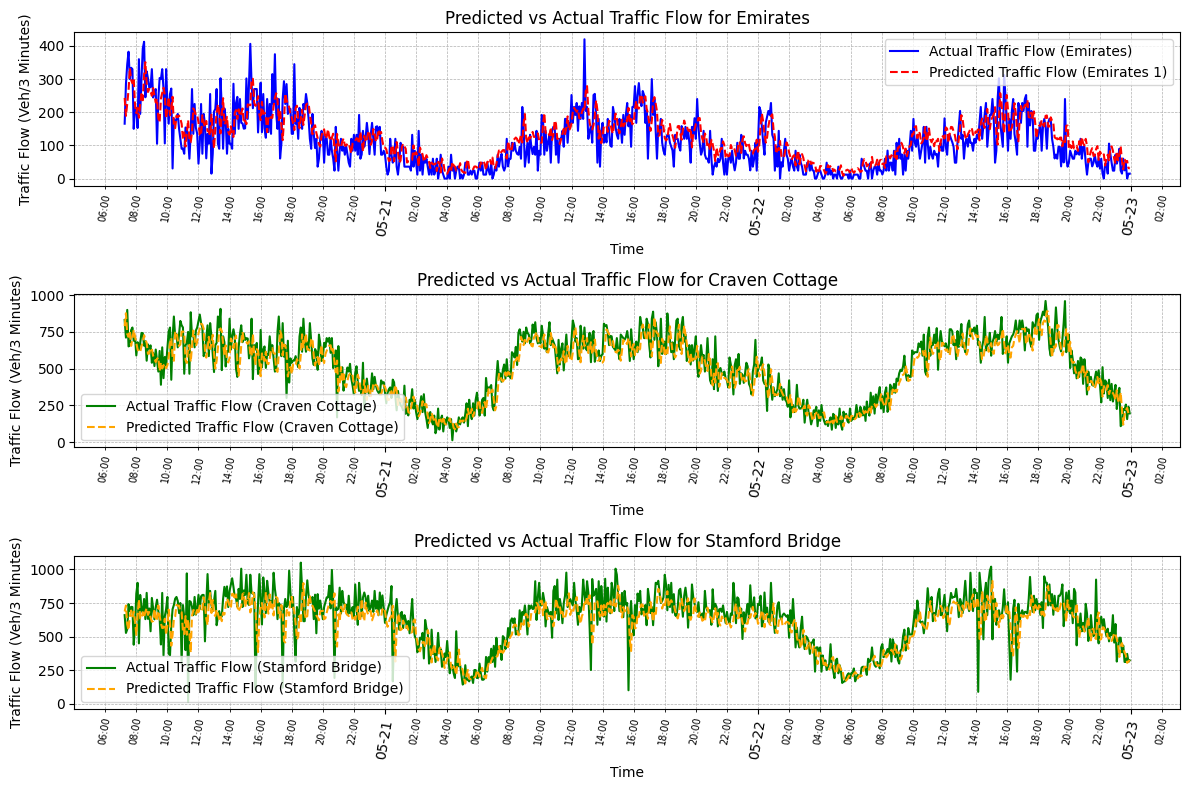

In [23]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

timestamps = time_flow.index[-len(y_val):]

fig = plt.figure(figsize=(12, 8))  # Set the figure size
gs = gridspec.GridSpec(3, 1)  # Adjust row heights if needed

# Top row, 2 plots
ax1 = fig.add_subplot(gs[0, :])  # First subplot (row 0, column 0)
ax2 = fig.add_subplot(gs[1, :])  # Second subplot (row 0, column 1)

ax3 = fig.add_subplot(gs[2, :])

# First plot on ax1 (Actual vs Predicted for Detector 1)
ax1.plot(timestamps, y_val_detector_1_rescaled, label='Actual Traffic Flow (Emirates)', color='blue')
ax1.plot(timestamps, y_pred_detector_1_rescaled, label='Predicted Traffic Flow (Emirates 1)', color='red', linestyle='--')
ax1.set_xlabel('Time')
ax1.set_ylabel('Traffic Flow (Veh/3 Minutes)')
ax1.set_title('Predicted vs Actual Traffic Flow for Emirates')
ax1.legend()

# Apply x-axis formatting to ax1
ax1.xaxis.set_major_locator(mdates.DayLocator())  # Major ticks for each day
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))  # Format as month-day
ax1.xaxis.set_minor_locator(mdates.HourLocator(interval=2))  # Minor ticks every 2 hours
ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))  # Format as hour:minute
ax1.tick_params(axis='x', which='minor', rotation=80, labelsize=7)  # Adjust minor ticks
ax1.tick_params(axis='x', which='major', rotation=80, labelsize=10)  # Adjust major ticks
ax1.grid(visible=True, which='both', linestyle='--', linewidth=0.5)  # Grid lines

# Second plot on ax2 (Actual vs Predicted for Detector 2)
ax2.plot(timestamps, y_val_detector_2_rescaled, label='Actual Traffic Flow (Craven Cottage)', color='green')
ax2.plot(timestamps, y_pred_detector_2_rescaled, label='Predicted Traffic Flow (Craven Cottage)', color='orange', linestyle='--')
ax2.set_xlabel('Time')
ax2.set_ylabel('Traffic Flow (Veh/3 Minutes)')
ax2.set_title('Predicted vs Actual Traffic Flow for Craven Cottage')
ax2.legend()

# Apply x-axis formatting to ax3
ax2.xaxis.set_major_locator(mdates.DayLocator())  # Major ticks for each day
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))  # Format as month-day
ax2.xaxis.set_minor_locator(mdates.HourLocator(interval=2))  # Minor ticks every 2 hours
ax2.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))  # Format as hour:minute
ax2.tick_params(axis='x', which='minor', rotation=80, labelsize=7)  # Adjust minor ticks
ax2.tick_params(axis='x', which='major', rotation=80, labelsize=10)  # Adjust major ticks
ax2.grid(visible=True, which='both', linestyle='--', linewidth=0.5)  # Grid lines

# third plot on ax2 (Actual vs Predicted for Detector 2)
ax3.plot(timestamps, y_val_detector_3_rescaled, label='Actual Traffic Flow (Stamford Bridge)', color='green')
ax3.plot(timestamps, y_pred_detector_3_rescaled, label='Predicted Traffic Flow (Stamford Bridge)', color='orange', linestyle='--')
ax3.set_xlabel('Time')
ax3.set_ylabel('Traffic Flow (Veh/3 Minutes)')
ax3.set_title('Predicted vs Actual Traffic Flow for Stamford Bridge')
ax3.legend()

# Apply x-axis formatting to ax2
ax3.xaxis.set_major_locator(mdates.DayLocator())  # Major ticks for each day
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))  # Format as month-day
ax3.xaxis.set_minor_locator(mdates.HourLocator(interval=2))  # Minor ticks every 2 hours
ax3.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))  # Format as hour:minute
ax3.tick_params(axis='x', which='minor', rotation=80, labelsize=7)  # Adjust minor ticks
ax3.tick_params(axis='x', which='major', rotation=80, labelsize=10)  # Adjust major ticks
ax3.grid(visible=True, which='both', linestyle='--', linewidth=0.5)  # Grid lines


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()